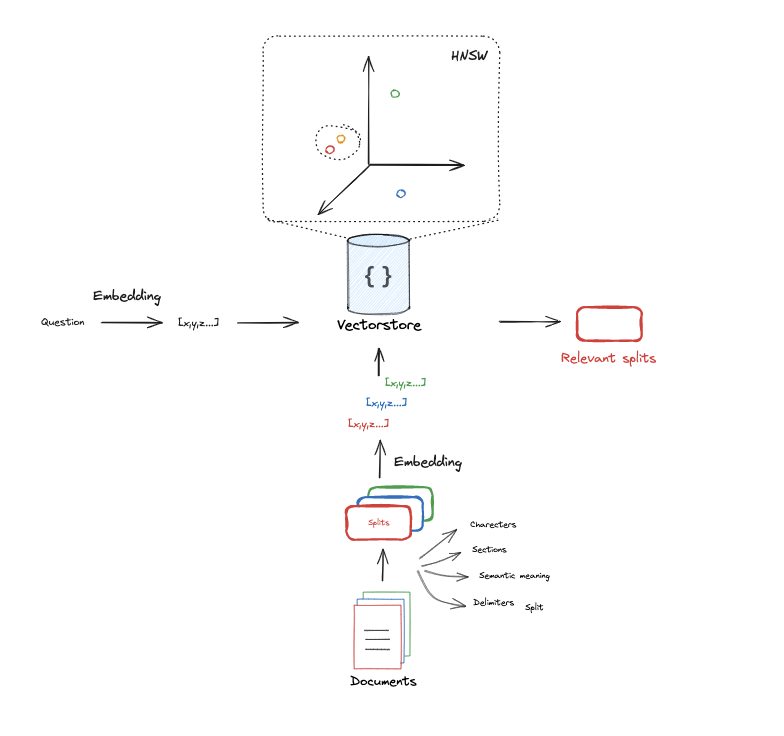

Source: https://python.langchain.com/docs/tutorials/retrievers/


If you run into an `import` problem in vscode, make sure you select the right python interpreter `> Python: Select Interpreter` and kernel `Notebook: Select Notebook Kernel`.

In [1]:
# type: ignore
import os

import dotenv
import numpy as np
import tiktoken
from httpx import ConnectError
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings

# import qdrant_client
# from llama_index.core import StorageContext
# from llama_index.vector_stores.qdrant import QdrantVectorStore
# from llama_index.core import VectorStoreIndex
from langchain_qdrant import QdrantVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from modules import utils
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

Set Project path

In [2]:
# load variables into env
root_dir = utils.get_project_root()
f = root_dir / ".secrets" / ".env"
assert f.exists(), f"File not found: {f}"
dotenv.load_dotenv(f)

Root Directory: /Users/firoozas/Documents/AI-from-scratch/RAG


True

## <span style='color:Orange;'>LangChain Document Object</span>

LangChain implements a Document abstraction, which is intended to represent a unit of text and associated metadata. It has three attributes:

- `page_content`: a string representing the content;
- `metadata`: a dict containing arbitrary metadata;
- `id`: (optional) a string identifier for the document.

The metadata attribute can capture **information about the source** of the document, its **relationship to other documents,** and other information. 

> _Note that an individual Document object often represents a chunk of a larger document._

In [3]:
documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.", metadata={"source": "mammal-pets-doc"}
    ),
]

### <span style='color:Khaki;'>Document loaders</span>

DocumentLoaders load data into the standard LangChain Document format.

[Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

See this guide for more detail on PDF document loaders.

[PDF Document Loader](https://python.langchain.com/docs/how_to/document_loader_pdf/)


In [4]:
file_path = root_dir / "data" / "vmd_sample.pdf"
assert os.path.exists(file_path)
loader = PyPDFLoader(file_path)

docs = loader.load()

print(f"{len(docs)=}")
print("CONTENT")
print(f"{docs[37].page_content[:200]}\n")
print(docs[0].metadata)

len(docs)=200
CONTENT
described in Chapter 4). If VMD is unable to guess the appropriate le type or guesses incorrectly,
you must select it from the list manually.
You can control into which VMD molecule you want to load 

{'source': '/Users/firoozas/Documents/AI-from-scratch/RAG/data/vmd_sample.pdf', 'page': 0}


#### <span style='color:LightGreen;'>Splitting Text</span>

[Recursive Text Splitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter)

Further splitting the PDF will help ensure that the meanings of relevant portions of the document are not "washed out" by surrounding text.

We will split our documents **into chunks of 1000 characters with 200 characters of overlap** between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the [`RecursiveCharacterTextSplitter`](https://python.langchain.com/docs/how_to/recursive_text_splitter/), which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

> This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [5]:
# `add_start_index=True`` will preserve the character index where each split Document starts within the initial Document, as a metadata attribute “start_index”.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)

# Make splits
all_splits = text_splitter.split_documents(docs)

len(all_splits)

626

[Count tokens](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb): consider that about each [4 charecters is a token](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)

In [6]:
temp_doc1 = "What kinds of pets do I like?"
temp_doc2 = "My favorite pet is a cat."


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


print("number of characters:", len(temp_doc1))
print("number of tokens:", num_tokens_from_string(temp_doc1, "cl100k_base"))
print("charecter per tokens:", len(temp_doc1) / num_tokens_from_string(temp_doc1, "cl100k_base"))

number of characters: 29
number of tokens: 8
charecter per tokens: 3.625


## <span style='color:Orange;'>Embeddings</span>

Vector search is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text.


### <span style='color:Khaki;'>Installing Ollama</span>

- [Installing Ollama](https://github.com/ollama/ollama?tab=readme-ov-file#ollama)

- [Available models](https://ollama.com/search)
- [OpenAI embedding model](https://python.langchain.com/docs/integrations/text_embedding/openai)

In [7]:
embeddings_model = OllamaEmbeddings(model="llama3.2")


# ollama server example
try:
    # embedding example
    vector_1 = embeddings_model.embed_query(all_splits[0].page_content)
    vector_2 = embeddings_model.embed_query(all_splits[1].page_content)

    embedding_length = len(vector_1)

    print("Both embedding have same length:", len(vector_1) == len(vector_2))
    print(f"Generated vectors of length {embedding_length}\n")
    print(vector_1[:5])
except ConnectError as e:
    print(e)
    print("Please install and run Ollama server locally or use the hosted version")

Both embedding have same length: True
Generated vectors of length 3072

[0.0018432532, -0.025140692, 0.014092629, -0.023098888, -0.0020301666]


## <span style='color:Orange;'>Vector stores</span>

##### <span style='color:Khaki;'>Option 1: Local Qdrant Vector DB (stored as sqlite)</span>
https://docs.llamaindex.ai/en/stable/examples/vector_stores/QdrantIndexDemo/

[Running Qdrant server locally](https://www.youtube.com/watch?v=G0qmO2iqx5M)

[Running Qdrant without a server](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)


```bash
pip install qdrant-client llama-index llama-index-vector-stores-qdrant langchain-qdrant
```

```python
client = QdrantClient(path=str(root_dir / "data" / "qdrant_db"))
client.create_collection(
    collection_name="VMD_PDF", vectors_config=VectorParams(size=embedding_length, distance=Distance.COSINE)
)
vector_store = QdrantVectorStore(client=client, collection_name="VMD_PDF", embedding=embeddings_model)
vector_store.add_documents(all_splits)
```

### <span style='color:Khaki;'>Option 2: In Memory</span>

```python
# Index
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=embedding_model)

# {"k": 1} returns the top 1 most similar document from a search.
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})
```

In [8]:
# Both in-memory and on-disk storage are slower than cloud MongoDB!

# client = QdrantClient(":memory:")

# client.create_collection(
#     collection_name="VMD_PDF", vectors_config=VectorParams(size=embedding_length, distance=Distance.COSINE)
# )

# vector_store = QdrantVectorStore(client=client, collection_name="VMD_PDF", embedding=embeddings_model)

# vector_store.add_documents(all_splits)



### <span style='color:Khaki;'>Option 3: Cloud MongoDB Atlas Vector DB</span>

- [Available DBs](https://python.langchain.com/docs/integrations/vectorstores/)
- [Get MongoDB Connection String](https://www.mongodb.com/docs/manual/reference/connection-string/)
- [Work with MongoDB Connection String](https://swethag04.medium.com/rag-using-mongodb-atlas-vector-search-and-langchain-cba57b67fe29)
- [Create Vector Search Index](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/)


#### <span style='color:LightGreen;'>Install Libraries</span>

```bash
pip install "pymongo[srv]"
```

#### <span style='color:LightGreen;'>Notes</span>

The `relevance_score_fn` parameter (in `MongoDBAtlasVectorSearch()`) in the client library ensures that the client understands how the relevance scores returned by MongoDB should be interpreted. It will not automatically create a "vector search index". It should be created manually.

  - [Cosine similarity](https://platform.openai.com/docs/guides/embeddings/frequently-asked-questions): Returns values typically between -1 (opposite) and 1 (identical).
  - Euclidean Distance: Returns non-negative values where 0 means identical, and larger numbers indicate greater dissimilarity.
  - Dot Product: Returns unbounded values where higher scores indicate greater similarity.


In [9]:
# example to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


similarity = cosine_similarity(embeddings_model.embed_query(temp_doc1),
                               embeddings_model.embed_query(temp_doc2))

print("Cosine Similarity:", similarity)

Cosine Similarity: 0.6737705309720553


In [10]:
# Create a new client and connect to the server
client = utils.AtlasClient(dbname="VMD_RAG", collection_name="VMD_PDF")
client.ping()

Ping: Successfully connected to MongoDB!


In [11]:
client.create_indexes(embeddings_model, index_name="pdf_cosine")

Index pdf_cosine already exists.


In [12]:
# Having instantiated our vector store, we can now index the documents.
if len(all_splits) != client.collection.count_documents({}):
    client.init_vector_store(embeddings_model)
    ids = client.vector_store.add_documents(documents=all_splits)
else:
    print("Documents already in the collection")

Documents already in the collection
